# **Understanding The PCA Implementation**

This notebook describes the custom PCA class that implements Principal Component Analysis (PCA) from scratch. The class follows a complete PCA pipeline, including dataset loading, standardization, eigenvalue decomposition, and dimensionality reduction.



---



## 1️⃣ **Importing Neccessary Libraries**

Before implementing Principal Component Analysis (PCA), we first essential libraries for data handling, preprocessing, dimensionality reduction, and evaluation. These include:

* `numpy, pandas, and seaborn` - For numerical operations and dataset handling.
* `scikit-learn.datasets` - For built-in datasets.
* `sklearn.preprocessing` - For standardization and encoding categorical variables.
* `scikit-learn.decomposition` - For sklearn PCA implementation.
* `scipy.stats` - For statistical computations.
* `matplotlib.pyplot` - For visualizing PCA results using scatter plots and scree plots.
* `requests and os` - For handling external datasets.
* `typing` - For function argument type definitions.


These libraries provide the tools required for dataset loading, preprocessing, and performing manual PCA calculations.

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn import datasets

from sklearn.decomposition import PCA as sklearnPCA
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.metrics.pairwise import euclidean_distances, cosine_similarity
from scipy.stats import pearsonr

import requests
import os
from typing import Union, Literal
import matplotlib.pyplot as plt

## 2️⃣ **PCA Class Implementation**

The `PCA` class implements Principal Component Analysis from scratch, following the fundamental steps of PCA. It supports:

* **Dataset loading from multiple sources** (`sklearn`, `seaborn`, `csv`, `excel`, `json`, `numpy`, `API`).
* **Standardizing the data** so that all features contribute equally.
* **Computing the covariance matrix** to measure relationships between variables.
* **Performing eigenvalue decomposition** to identify the new feature space.
* **Sorting and selecting the most significant principal components.**
* **Projecting the original dataset into a lower-dimensional subspace.**
* **Visualizing PCA results** using **Scree Plots** and **2D scatter plots.**
* **Analyzing distance preservation** after PCA transformation.

Each step in PCA is implemented as a method within the class to enhance the learning experience.

In [ ]:
class PCA:
    matrix = None
    standardized_matrix = None
    covariance_matrix = None

    eigenvalues = None
    eigenvectors = None
    sorted_eigenvalues = None
    sorted_eigenvectors = None

    principal_components = None
    projected_matrix = None

    explained_variance_ratio = None

    def __init__(self, matrix=None):
        """
        Initialize the PCA object with a matrix (optional).
        """

        if matrix is not None and (isinstance(matrix, np.ndarray) or self._check_matrix_structure(matrix)):
            self.matrix = np.array(matrix)
        elif matrix:
            raise ValueError('Please provide a valid matrix')

    def _check_matrix_structure(self, matrix):
        """
        Check if the matrix is a valid matrix.
        """
        if isinstance(matrix, list):
            return all(self._check_matrix_structure(item) for item in matrix)
        elif isinstance(matrix, (int, float)):
            return True
        else:
            return False

    def load_dataset(self, name:str = None, platform:Union[Literal["sklearn", "seaborn", "csv", "excel", "json", "numpy", "api"], None] = None):
        """
        Loads a dataset from various sources and converts it into a NumPy matrix after cleaning.
        """

        if (name and not platform) or (not name and platform):
            raise ValueError("Please provide both 'name' and 'platform' parameters.")
        elif not name and not platform and self.matrix is not None:
            return None
        elif not name and not platform:
            raise ValueError("Please provide either 'name' and 'platform' parameters or pass a matrix at initialization.")

        df = None
        if platform == "sklearn":
            try:
                dataset = getattr(datasets, f"load_{name}")()
                df = pd.DataFrame(dataset.data, columns=dataset.feature_names)
            except AttributeError:
                raise ValueError(f"Dataset '{name}' not found in scikit-learn.")
        elif platform == "seaborn":
            try:
                df = sns.load_dataset(name)
            except ValueError:
                raise ValueError(f"Dataset '{name}' not found in Seaborn.")
        elif platform == "csv":
            if os.path.exists(name) or name.startswith("http"):
                df = pd.read_csv(name)
            else:
                raise FileNotFoundError(f"CSV file '{name}' not found.")
        elif platform == "excel":
            if os.path.exists(name):
                df = pd.read_excel(name)
            else:
                raise FileNotFoundError(f"Excel file '{name}' not found.")
        elif platform == "json":
            if os.path.exists(name):
                df = pd.read_json(name)
            else:
                raise FileNotFoundError(f"JSON file '{name}' not found.")
        elif platform == "numpy":
            if os.path.exists(name):
                df = pd.DataFrame(np.load(name))
            else:
                raise FileNotFoundError(f"Numpy file '{name}' not found.")
        elif platform == "api":
            response = requests.get(name)
            if response.status_code == 200:
                data = response.json()
                df = pd.DataFrame(data)
            else:
                raise ConnectionError(f"Failed to fetch data from API '{name}'.")
        else:
            raise ValueError(f"Unsupported platform: {platform}")

        if df is not None:
            df = df.convert_dtypes()
            for col in df.select_dtypes(include=['object']).columns: # Handle non-numerical columns
                if df[col].nunique() <= 10:  # Use one-hot encoding for small categories
                    encoder = OneHotEncoder(sparse=False)
                    encoded = encoder.fit_transform(df[[col]])
                    df = df.drop(columns=[col])
                    df = pd.concat([df, pd.DataFrame(encoded, index=df.index)], axis=1)
                else:  # Use label encoding for large categories
                    encoder = LabelEncoder()
                    df[col] = encoder.fit_transform(df[col])
            df = df.apply(pd.to_numeric, errors='coerce')
            df = df.fillna(0)
            df.replace([np.inf, -np.inf], np.nan, inplace=True)
            df.dropna(inplace=True)
            self.matrix = df.to_numpy(dtype=np.float64)
            print(f"Dataset loaded from {platform}: {name} \nShape: {self.matrix.shape}")
        else:
            raise ValueError(f"Failed to load dataset from {platform}: {name}")

    def standardize_data(self):
        """
        Standardize the data by subtracting the mean and dividing by the standard deviation.
        """

        if self.matrix is None:
            raise ValueError("Please load a dataset first.")

        mean = np.mean(self.matrix, axis=0)
        std_dev = np.std(self.matrix, axis=0)
        std_dev[std_dev == 0] = 1 # Prevent division by zero (set std_dev=1 where std_dev=0)
        self.standardized_matrix = (self.matrix - mean) / std_dev

    def compute_covariance_matrix(self):
        """
        Compute the covariance matrix of the standardized data.
        """

        if self.standardized_matrix is None:
            raise ValueError("Please standardize the data first.")

        self.covariance_matrix = np.cov(self.standardized_matrix.T)

    def compute_eigenvalues_and_eigenvectors(self):
        """
        Compute the eigenvalues and eigenvectors of the covariance matrix.
        """

        if self.covariance_matrix is None:
            raise ValueError("Please compute the covariance matrix first.")

        self.eigenvalues, self.eigenvectors = np.linalg.eig(self.covariance_matrix)

    def sort_eigenvalues_and_eigenvectors(self):
        """
        Sort the eigenvalues and eigenvectors in descending order.
        """

        if self.eigenvalues is None or self.eigenvectors is None:
            raise ValueError("Please compute the eigenvalues and eigenvectors first.")

        idx = self.eigenvalues.argsort()[::-1]
        self.sorted_eigenvalues = self.eigenvalues[idx]
        self.sorted_eigenvectors = self.eigenvectors[:, idx]

    def find_k_principal_components(self, k:int = 2):
        """
        Select the top k eigenvectors to form the principal components.
        """

        if self.sorted_eigenvectors is None or self.sorted_eigenvalues is None:
            raise ValueError("Please sort the eigenvalues and eigenvectors first.")
        elif k > len(self.sorted_eigenvectors):
            raise ValueError("k cannot be greater than the number of features.")

        self.principal_components = self.sorted_eigenvectors[:, :k]

    def project_data_to_k_dimensions(self):
        """
        Project the data to k dimensions using the top k principal components.
        """

        if self.principal_components is None:
            raise ValueError("Please find the k principal components first.")

        self.projected_matrix = self.standardized_matrix.dot(self.principal_components)

    def compute_explained_variance_ratio(self):
        """
        Compute the explained variance of the principal components.
        """

        if self.sorted_eigenvalues is None:
            raise ValueError("Please sort the eigenvalues and eigenvectors first.")

        self.explained_variance_ratio = self.sorted_eigenvalues / np.sum(self.sorted_eigenvalues)

    def plot_scree(self):
        """
        Plot the scree plot of explained variances rartios versus the number of components.
        """

        if self.explained_variance_ratio is None:
            raise ValueError("Please compute the explained variance ratio first.")

        plt.plot(range(1, len(self.explained_variance_ratio) + 1), self.explained_variance_ratio, color='red')
        plt.xlabel('Components', fontsize=14)
        plt.ylabel('Explained Variance Ratios', fontsize=14)
        plt.xticks(range(1, len(self.explained_variance_ratio) + 1))
        plt.title('Manual Scree Plot', fontsize=16)
        plt.show()

    def plot_2d(self):
        """
        Plot the 2D projection of the data.
        """

        if self.projected_matrix is None:
            raise ValueError("Please project the data to k dimensions first.")
        if self.projected_matrix.shape[1] < 2:
            raise ValueError("Matrix has less than 2 dimensions.")

        plt.scatter(self.projected_matrix[:, 0], self.projected_matrix[:, 1], c='red')
        plt.xlabel('Principal Component 1', fontsize=14)
        plt.ylabel('Principal Component 2', fontsize=14)
        plt.title('2D Projection of Data', fontsize=16)
        plt.show()

##3️⃣ **Initialization Functions**

To streamline the workflow, we define two initialization functions:

* `initialize_manual_pca_iris()`
* `initialize_sklearn_pca_iris()`

These functions:

* Load the **Iris dataset** by default.
* Apply **manual PCA** and **Scikit-Learn PCA.**
* Standardize the data before PCA transformation.
* Store the transformed data for visualization and comparison.

In [ ]:
def initialize_manual_pca(name:str = 'iris', platform:str = 'sklearn', k:int = 2):
    """
    Initialize a manual PCA object and perform PCA on the iris dataset by default.
    """

    pca = PCA()
    pca.load_dataset(name=name, platform=platform)
    pca.standardize_data()
    pca.compute_covariance_matrix()
    pca.compute_eigenvalues_and_eigenvectors()
    pca.sort_eigenvalues_and_eigenvectors()
    pca.find_k_principal_components(k)
    pca.project_data_to_k_dimensions()
    pca.compute_explained_variance_ratio()

    return pca

def initialize_sklearn_pca_iris():
    """
    Initialize a sklearn PCA object and perform PCA on the iris dataset.
    """

    data = datasets.load_iris()
    X = data.data

    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    pca = sklearnPCA(n_components=X.shape[1])
    pca.fit(X_scaled)

    return pca

def plot_pca_iris_scree(pca):
    """
    Plot the scree plot of the iris dataset.
    """

    explained_variance_ratio = pca.explained_variance_ratio_
    plt.plot(range(1, len(explained_variance_ratio) + 1), explained_variance_ratio, c='red')
    plt.xlabel("Components", fontsize=14)
    plt.ylabel("Explained Variance Ratios", fontsize=14)
    plt.xticks(range(1, len(explained_variance_ratio) + 1))
    plt.title("Sklearn Scree Plot", fontsize=16)
    plt.show()

def plot_iris_2d():
    """
    Plot the first 2 dimensions of the iris dataset without PCA.
    """

    iris = datasets.load_iris()
    X = iris.data

    plt.scatter(X[:, 0], X[:, 1], c='red')
    plt.xlabel('Dimension 1', fontsize=14)
    plt.ylabel('Dimension 2', fontsize=14)
    plt.title('Iris Dataset', fontsize=16)
    plt.show()

## 📌 **Implement PCA from Scratch**

In [ ]:
# Initialize the manual PCA object and perform PCA on the iris dataset
manual_pca = initialize_manual_pca()

# Initialize the sklearn PCA object and perform PCA on the iris dataset
sklearn_pca = initialize_sklearn_pca_iris()

Dataset loaded from sklearn: iris 
Shape: (150, 4)


## 📌 **Compare with Scikit-Learn's PCA**

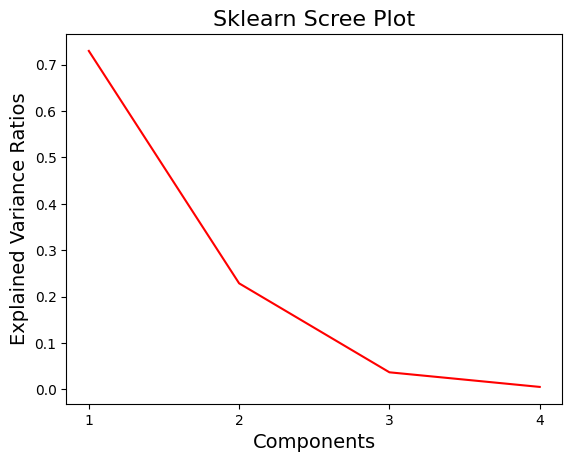

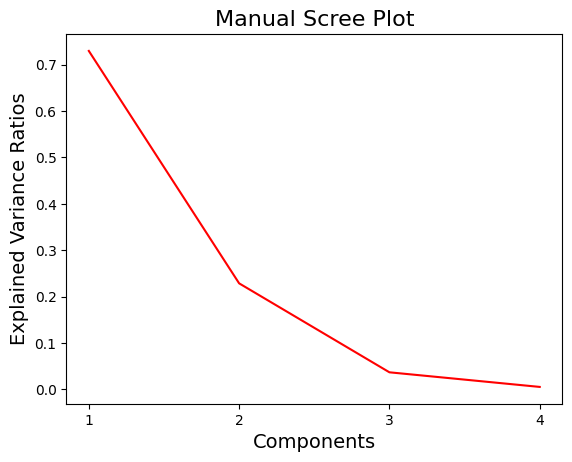

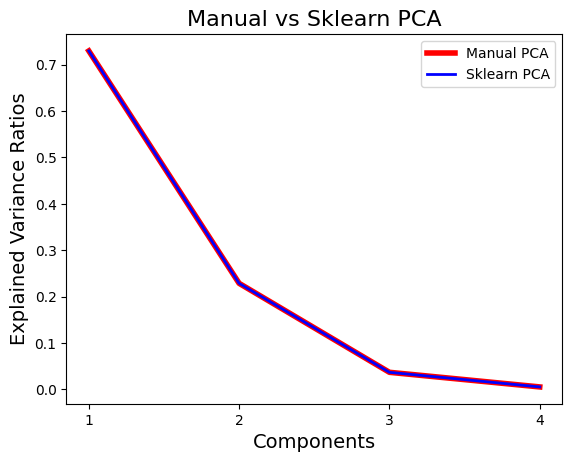

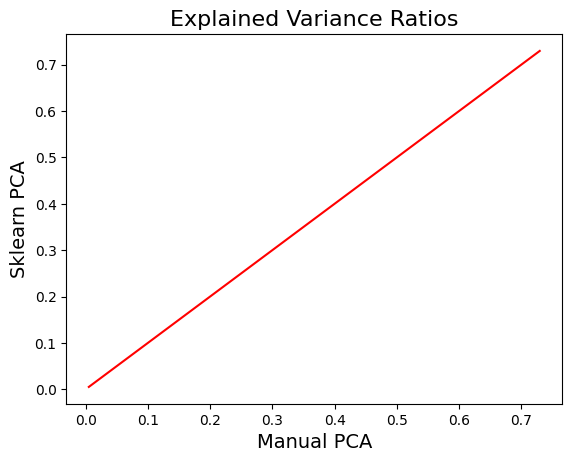

In [ ]:
# Plot the scree plot of the iris dataset using sklearn PCA
plot_pca_iris_scree(sklearn_pca)

# Plot the scree plot of the iris dataset using manual PCA
manual_pca.plot_scree()

# Plot the explained variance ratios of manual and sklearn PCA
plt.plot(range(1, len(manual_pca.explained_variance_ratio) + 1), manual_pca.explained_variance_ratio, color='red', linewidth=4, label='Manual PCA')
plt.plot(range(1, len(sklearn_pca.explained_variance_ratio_) + 1), sklearn_pca.explained_variance_ratio_, color='blue', linewidth=2, label='Sklearn PCA')
plt.xlabel('Components', fontsize=14)
plt.ylabel('Explained Variance Ratios', fontsize=14)
plt.title('Manual vs Sklearn PCA', fontsize=16)
plt.xticks(range(1, len(manual_pca.explained_variance_ratio) + 1))
plt.legend()
plt.show()

# Plot the explained variance ratio of manual PCA vs sklearn PCA
plt.plot(manual_pca.explained_variance_ratio, sklearn_pca.explained_variance_ratio_, color='red')
plt.xlabel('Manual PCA', fontsize=14)
plt.ylabel('Sklearn PCA', fontsize=14)
plt.title('Explained Variance Ratios', fontsize=16)
plt.show()

## 📌 **Visualizing PCA**

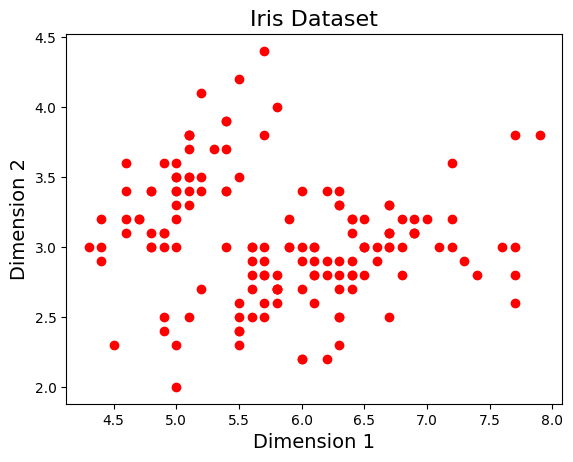

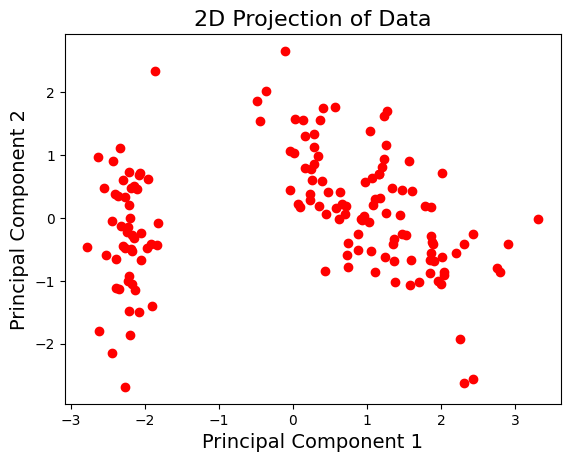

Explained variances in descending order: 
0.7296 0.2285 0.0367 0.0052 

In [ ]:
# Plot the first 2 dimensions of the iris dataset without PCA
plot_iris_2d()

# Plot the first 2 components of the iris dataset using manual PCA
manual_pca.plot_2d()

print("Explained variances in descending order: ")
for x in manual_pca.explained_variance_ratio:
  print(round(x, 4), end=" ")

## 📌 **Apply PCA on High-Dimensional Dataset**
Apply PCA to a high-dimensional dataset with at least 100 features, and I have chosen the Arrhythmia dataset.

The Arrhythmia dataset is designed for medical classification tasks, particularly to identify different types of cardiac arrhythmia (irregular heartbeats). It contains **279** numerical attributes extracted from ECG (electrocardiogram) recordings, along with a class label that indicates the presence and type of arrhythmia. It has **452** patient entries.

The dataset is mainly used for pattern recognition in medical data, machine learning classification, and feature selection studies.

In [ ]:
# Initialize the manual PCA object and perform PCA on the arrhythmia dataset
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/arrhythmia/arrhythmia.data"
manual_pca_high_dimensional = initialize_manual_pca(name=url, platform='csv')

Dataset loaded from csv: https://archive.ics.uci.edu/ml/machine-learning-databases/arrhythmia/arrhythmia.data 
Shape: (451, 280)


## 📌 **Variance Explanation**

The minimum number of principal components required to explain at least 95% of the total variance is: 103 with 95.0075% variance


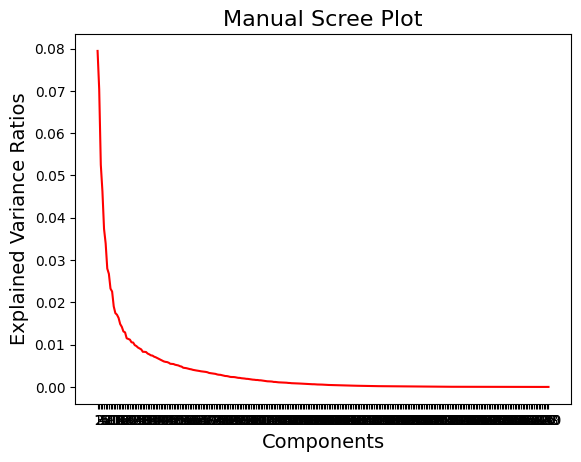

In [ ]:
# Determine the minimum number of principal components required to explain at least 95% of the total variance in the dataset
explained_variance_ratio = manual_pca_high_dimensional.explained_variance_ratio
k = 0
variance = 0

while variance < 0.95:
    variance += explained_variance_ratio[k]
    k += 1

print(f"The minimum number of principal components required to explain at least 95% of the total variance is: {k} with {(variance * 100):.4f}% variance")

# Visualize the explained variance ratio as a function of the number of components
manual_pca_high_dimensional.plot_scree()

## 📌 **Distance Preservation**

Pearson correlation between original and PCA-transformed distances: 0.9996


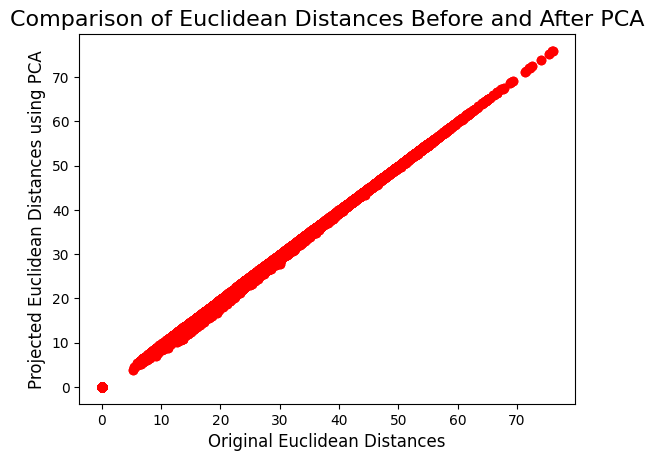

Pearson correlation between original and PCA-transformed cosine similarity: 0.9978


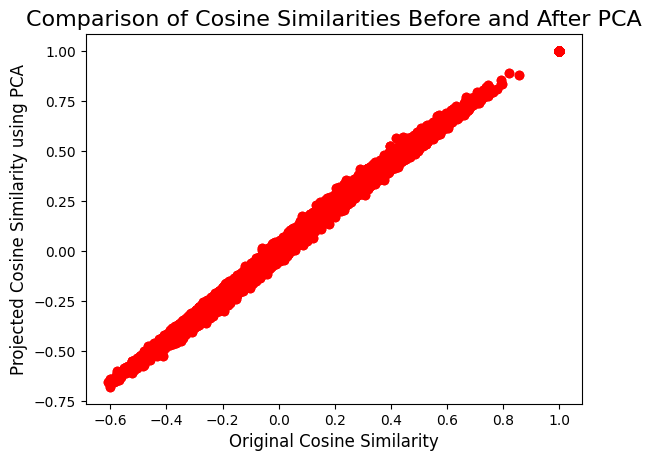

In [ ]:
# Find these k principle components which achieve 95% variance and project the data onto these k dimensions
manual_pca_high_dimensional.find_k_principal_components(k)
manual_pca_high_dimensional.project_data_to_k_dimensions()

# Compare Euclidean distances before and after dimensionality reduction
original_distances = euclidean_distances(manual_pca_high_dimensional.standardized_matrix)
projected_distances = euclidean_distances(manual_pca_high_dimensional.projected_matrix)
original_distances = original_distances.flatten()
projected_distances = projected_distances.flatten()

# Compute Pearson correlation between original and projected distances
correlation, _ = pearsonr(original_distances, projected_distances)
print(f"Pearson correlation between original and PCA-transformed distances: {correlation:.4f}")

# Plot the original distances vs. the projected distances
plt.scatter(original_distances, projected_distances, c='red')
plt.xlabel("Original Euclidean Distances", fontsize=12)
plt.ylabel("Projected Euclidean Distances using PCA", fontsize=12)
plt.title("Comparison of Euclidean Distances Before and After PCA", fontsize=16)
plt.show()


# Compare Cosine Similarity before and after dimensionality reduction
original_cosine_sim = cosine_similarity(manual_pca_high_dimensional.standardized_matrix)
projected_cosine_sim = cosine_similarity(manual_pca_high_dimensional.projected_matrix)
original_cosine_sim = original_cosine_sim.flatten()
projected_cosine_sim = projected_cosine_sim.flatten()

# Compute Pearson correlation between original and projected distances
correlation, _ = pearsonr(original_cosine_sim, projected_cosine_sim)
print(f"Pearson correlation between original and PCA-transformed cosine similarity: {correlation:.4f}")

# Plot the original distances vs. the projected distances
plt.scatter(original_cosine_sim, projected_cosine_sim, c='red')
plt.xlabel("Original Cosine Similarity", fontsize=12)
plt.ylabel("Projected Cosine Similarity using PCA", fontsize=12)
plt.title("Comparison of Cosine Similarities Before and After PCA", fontsize=16)
plt.show()

## **Discussion of Results**

### 1️⃣ **Euclidean Distance Preservation**

📊 Pearson Correlation = 0.9996

* The extremely high correlation suggests that PCA nearly perfectly preserves Euclidean distances when working with standardized data.
* The scatter plot forms a near-perfect diagonal, meaning that relative distances between points remain almost unchanged.
* There is almost no distortion, indicating that PCA did not significantly alter pairwise distances.

Implications for Clustering:

* Cluster separations remain intact since distance-based clustering (e.g., K-Means, hierarchical clustering) relies on Euclidean distance.
* Minimal impact on distance-based classification tasks, such as K-NN.


---



### 2️⃣ **Cosine Similarity Preservation**

📊 Pearson Correlation = 0.9978

* The high correlation suggests that PCA preserved cosine similarities almost perfectly.
* The scatter plot is tightly clustered along the diagonal, indicating that angular relationships between vectors remain nearly unchanged.
* This means that PCA does not significantly affect cosine-based similarity measures when applied to standardized data.

Implications for Clustering:

* Cosine-based clustering methods (e.g., Spectral Clustering, K-Means with cosine distance) remain valid after PCA.
* Text/NLP applications that rely on cosine similarity should not be significantly impacted.
* Nearest-neighbor methods using cosine similarity will still return meaningful neighbors, as angular relationships are retained.


---



### 3️⃣ **Why Did PCA Preserve Both Distance and Cosine Similarity?**

* PCA is fundamentally a rotation and projection—it does not distort structure if enough variance is retained.
* Euclidean distances and cosine similarities were preserved because the transformation primarily reoriented the data without significant loss of information.